# Controlisation of Hamiltonian Simulation

I try to construct not the circuit for $e^{iHt}$, but the controlled version of it. First of all, note that if we have $U = A \cdot B \cdot C$ circuit, where $A$, $B$ and $C$ are some operators, then the controlled version of that circuit will be equal to $cU = cA \cdot cB \cdot cC$, where $c$ denotes control version of an operator. We already know that in the Trotter decomposition $e^{iHt}$ consists of $e^{iPt}$ terms, where $P$ is a Pauli term. Therefore, the controlled version of the $e^{iHt}$ can be constructed with the controlled versions of the same $e^{iPt}$ terms. Here is a general form of the circuit that implements any given $e^{iPt}$ and the controlled version of it for the three-qubit case [[1]]:

<img src="exp_pauli_and_controled.png" alt="drawing" width="670"/>

where $O_i$ are gates from the set $\{I, H, H_y\}$, and they are chosen differently for each Pauli term. The right circuit in the picture implements the controlled version of the $e^{iPt}$, because, if control qubit is in the $\left| 0 \right\rangle$ state the $R_z$ gate will not work and the rest gates will cancel each other (they are self-inverse gates) [[1]]. 

The controlled-$e^{iIt}$ in the controlled-$e^{iHt}$ is not a global phase. Let's call it controlled-global phase gate ($CGP$). The effect of $CGP$ for controlled qubit $\alpha \left| 0_c \right\rangle + \beta \left| 1_c \right\rangle$ acting on multi-qubit $\left| \psi \right\rangle$ state:

$$ CGP \big( \left( \alpha \left| 0_c \right\rangle + \beta \left| 1_c \right\rangle \right) \left| \psi \right\rangle \big) = \left( \alpha \left| 0_c \right\rangle + e^{it}\beta \left| 1_c \right\rangle \right) \left| \psi \right\rangle$$

This action can be done just by one Qiskit's $u1$ phase gate acting on the control qubit [[2]]:

$$ u1(t) \otimes I \big( \left( \alpha \left| 0_c \right\rangle + \beta \left| 1_c \right\rangle \right) \left| \psi \right\rangle \big) = \left( \alpha \left| 0_c \right\rangle + e^{it} \beta \left| 1_c \right\rangle \right) \left| \psi \right\rangle,$$

where

$$u1(t) = \begin{pmatrix} 1 & 0 \\ 0 & e^{it}\end{pmatrix}$$

  [1]: https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441
  [2]: https://www.cambridge.org/am/academic/subjects/physics/quantum-physics-quantum-information-and-quantum-computation/quantum-computation-and-quantum-information-10th-anniversary-edition?format=HB

<h3 align="left">
The code
</h3>

Before going into Qiskit code, note that:

\begin{equation*}
H_y = u2(\pi/2, \pi/2)
\qquad \qquad
H = u2(0, \pi)
\\
u2(\varphi, \lambda) = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & -e^{i\lambda} \\
e^{i\varphi} & e^{i(\varphi + \lambda)}
\end{pmatrix}
\end{equation*}

So, I implement $H_y$ with $u2(\pi/2, \pi/2)$ gate in the code, where $u2$ is one of the Qiskit basis gates. For $H$ gate I use either $h$ gate or $u2(0, \pi)$ gate in the code.

Firstly let us define what Hamiltonian I want to simulate. Let's do simulation for this Hamiltonian:

$$H = 2 \cdot \sigma_x \otimes \sigma_z \otimes \sigma_x + 5 \cdot \sigma_z \otimes \sigma_y \otimes I + 7 \cdot I \otimes \sigma_y \otimes \sigma_z$$

It can be shown that all three terms commute to each other, thus we can write $e^{iHt}$ in this form without Trotter decomposition:

$$e^{iHt} = e^{i2 \cdot \sigma_x \otimes \sigma_z \otimes \sigma_x t} \; \cdot \; e^{i5 \cdot \sigma_z \otimes \sigma_y \otimes I t} \; \cdot \; e^{i7 \cdot I \otimes \sigma_y \otimes \sigma_z t}$$

The fact that we don't need to do Trotter decomposition will help us to have a simple circuit. Now let's start coding:

In [1]:
from qiskit import *
import numpy as np

In [2]:
def exp_all_z(circuit, quantum_register, pauli_idexes, control_qubit=None, t=1):
    if len(pauli_idexes) == 0 and control_qubit is not None:
        circuit.u1(t, control_qubit)
        return

    for i in range(len(pauli_idexes) - 1):
        circuit.cx(quantum_register[pauli_idexes[i]], quantum_register[pauli_idexes[i + 1]])

    if control_qubit is None:
        circuit.rz(2 * t, quantum_register[pauli_idexes[-1]])
    else:
        circuit.crz(2 * t, control_qubit, quantum_register[pauli_idexes[-1]])

    for i in reversed(range(len(pauli_idexes) - 1)):
        circuit.cx(quantum_register[pauli_idexes[i]], quantum_register[pauli_idexes[i + 1]])

In [3]:
def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    if len(pauli) != len(quantum_register):
        raise Exception("Pauli string doesn't match to the quantum register")

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u(np.pi / 2, np.pi / 2, 0, quantum_register[i])
            pauli_idexes.append(i)

    pauli_circuit = pauli_circuit.compose(circuit_bracket)
    exp_all_z(pauli_circuit, quantum_register, pauli_idexes, control_qubit, t)
    pauli_circuit = pauli_circuit.compose(circuit_bracket.inverse())

    return pauli_circuit

In [4]:
def hamiltonian_simulation(hamiltonian, quantum_register=None, control_qubit=None, t=1, trotter_number=1):
    if quantum_register is None:
        quantum_register = QuantumRegister(len(list(hamiltonian.keys())[0]))
    if control_qubit in quantum_register:
        raise Exception("the control qubit is in the target register")

    delta_t = t / trotter_number
    exp_hamiltonian = QuantumCircuit(quantum_register)

    for i in range(trotter_number):
        exp_delta_t = QuantumCircuit(quantum_register)
        for pauli in hamiltonian:
            weight = hamiltonian[pauli]
            exp_delta_t = exp_delta_t.compose(exp_pauli(pauli, quantum_register, control_qubit, weight * delta_t))
        exp_hamiltonian = exp_hamiltonian.compose(exp_delta_t)

    return exp_hamiltonian

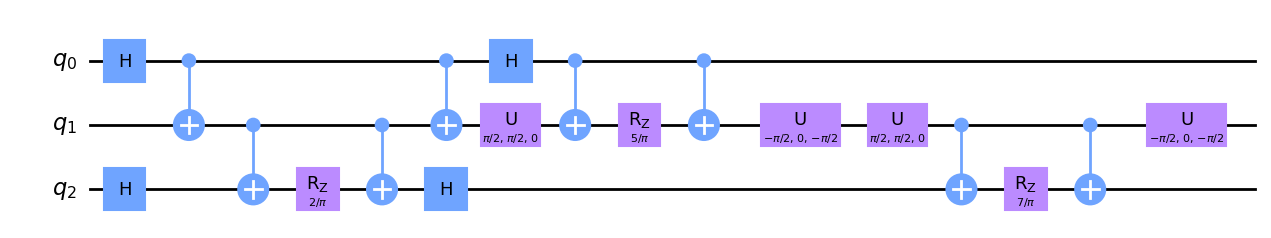

In [5]:
# Example usage
hamiltonian = {"XZX": 2, "ZYI": 5, "IYZ": 7}
quantum_register = QuantumRegister(3, 'q')
circuit = hamiltonian_simulation(hamiltonian, quantum_register, t=1/(2*np.pi))

# draw the circuit 
%matplotlib inline
circuit.draw(output="mpl")

In [10]:
# # Add the control qubit to the same circuit
# control_qubit = QuantumRegister(1, 'c')

# control_circuit = QuantumCircuit(quantum_register, control_qubit)
# # Assuming the function takes a circuit as an argument
# hamiltonian_circuit = hamiltonian_simulation(hamiltonian, quantum_register, control_qubit[0], t=1/(2*np.pi))

# # Append the resulting circuit to the combined circuit
# combined_circuit.append(hamiltonian_circuit, quantum_register)
# # Draw the final circuit
# combined_circuit.draw(output="mpl") 